Single spillover (non-recurrent) with finite population and SIS dynamics WITHOUT death. (no natural death, no disease-induced death)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#class representing one simulation.

class Sim:
    def __init__(self, times, betas, gammas, I, S):
        
        #these are all arrays of the same length
        self.times = times #all the times of new events (infections and recoveries)
        self.betas = betas #the corresponding betas. if the event was a recovery, the corresponding beta is "None"
        self.gammas = gammas #the corresponding gammas. if the event was a recovery, the corresponding gamma is "None"
        self.I = I #the number of infecteds, inclusive of the new event
        self.S = S #the number of susceptibles, inclusive of the new event
        
    def append(self, t, beta, gamma, I, S):
        self.times.append(t)
        self.betas.append(beta)
        self.gammas.append(gamma)
        self.I.append(I)
        self.S.append(S)

In [4]:
def sim_finite(S_0, beta_0, gamma_0, mu_1=0, mu_2=0, t_thresh = 1000, I_0=1):

    #initialize time variable
    t=0
    
    #initialize return object
    sim = Sim([t], [beta_0], [gamma_0], [I_0], [S_0])
    
    #initialize counters
    S = S_0; I = I_0
    
    #initialize matrix of active cases. each case is a row of length 3 that looks like [beta, gamma, time of infection] of that person. 
    infecteds=np.array([[beta_0, gamma_0, t]]*I_0)
    
    #initialize running sums of beta, gamma over all currently infected people    
    beta_sum = beta_0*I_0; gamma_sum = gamma_0*I_0
    
    
    while True:
        
        total_pop = S + I #total population
        
        #grab arrays of all betas, gammas of currently infected people
        betas = infecteds[:,0]; gammas = infecteds[:,1]
        
        #adjust betas to actual transmission rates, which depend on proportion of population that is susceptible
        trans_rates = betas*S/total_pop
        trans_rates_sum = beta_sum*S/total_pop #sum all transmission rates
        
        
        #compute interevent time (for the whole population)
        
        #rate of events is sum of transmission rate and gamma over all infected people
        overall_rate = trans_rates_sum + gamma_sum
        
        #draw from exponential distribution with this rate
        dt = np.random.exponential(scale=1/overall_rate) #interevent time
        t += dt #actual time of new event
        
        #return if next event is later than t_thresh
        if t > t_thresh: return sim
        
        #otherwise figure out who the event happened to
        i = np.random.choice(I, p=(trans_rates+gammas)/overall_rate) #draw index of that person
        
        #grab their specific beta, gamma, transmission rate
        beta = betas[i]; gamma = gammas[i]; trans_rate = beta*S/total_pop
        
        #figure out what they did: transmit, recover, or die
        ev = np.random.rand() #draw from uniform distribution over [0, 1)
        prob_trans = trans_rate / (trans_rate + gamma) #probability of transmission
        
        if (ev < prob_trans): #transmission

            #pick beta, gamma for new case
            #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2 respectively
            #don't allow negative beta or gamma.
            mut1 = np.random.normal(loc=0.0, scale=mu_1); mut2 = np.random.normal(loc=0.0, scale=mu_2)
            new_beta = max(0, beta + mut1)
            new_gamma = max(0, gamma + mut2)

            #append new case to array of currently infected people
            infecteds = np.append(infecteds, [[new_beta, new_gamma, t]], axis=0)

            #update counters
            I += 1; S -= 1
            
            #update running sums
            beta_sum += new_beta; gamma_sum += new_gamma
            
            #update return object
            sim.append(t, new_beta, new_gamma, I, S)

        else: #recovery
            
            infecteds = np.delete(infecteds, i, axis=0)
            
            #update counters
            I -= 1; S += 1
            
            #update running sums
            beta_sum -= beta; gamma_sum -= gamma
            
            #update return object
            sim.append(t, None, None, I, S)
            
            #check for extinction and return if so
            if I == 0: return sim

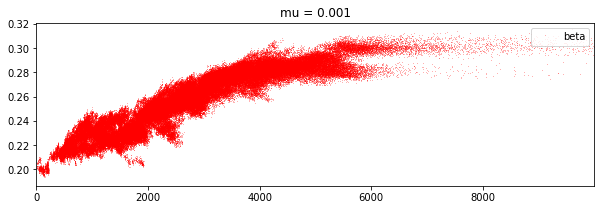

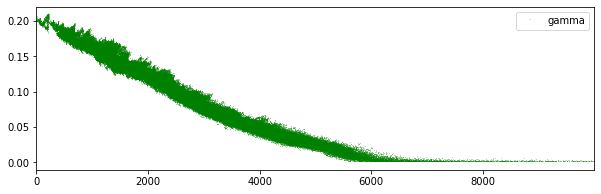

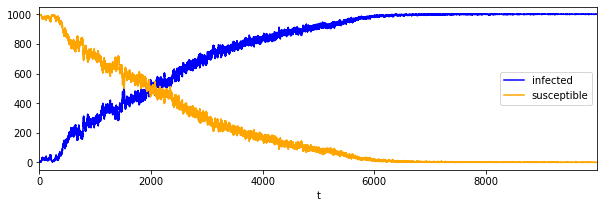

CPU times: user 32.5 s, sys: 220 ms, total: 32.7 s
Wall time: 32.9 s


In [7]:
%%time 

#parameters
S_0 = 1000
I_0 = 1

beta_0 = 0.2
gamma_0 = 0.2

mu = 0.001
mu_1 = mu; mu_2 = mu

t_thresh = 10000


s = None

while True:
    s = sim_finite(S_0, beta_0, gamma_0, mu_1, mu_2, t_thresh, I_0)
    if s.times[-1] > 500: break #get a simulation where the disease spreads for at least this many days
    #break
        
times = s.times; betas = s.betas; gammas = s.gammas; I = s.I; S = s.S

#plot betas over time
plt.figure(figsize=(10,3))
plt.plot(times, betas, ",r", alpha = 0.3, label='beta')
plt.title('mu = {}'.format(mu_1))
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="upper right"); plt.show()

#plot gammas over time
plt.figure(figsize=(10,3))
plt.plot(times, gammas, ",g", alpha = 0.3, label='gamma')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="upper right"); plt.show()

#plot I and S over time
plt.figure(figsize=(10,3))
plt.plot(times, I, 'blue', label='infected')
plt.plot(times, S, 'orange', label='susceptible')
plt.xlabel("t")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="center right"); plt.show()

In [6]:
#for saving (pickling) sample simulations
import pickle

In [ ]:
#10000 days simulation with mu = 0.001, beta = 0.1, gamma = 0.1, S_0 = 1000
#pickled to: s_single_spill_10000.txt

#describe simulation
#pickled to: 

file = open('file.txt', 'wb')
pickle.dump(s, file)
file.close()

In [ ]:
#open a pickled simulation

file = open('s_single_spill_10000.txt', 'rb')
s = pickle.load(file)
file.close()